In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
"""
Load the data set we will be working with
"""

data_dir = 'Datasets'
dataset_name = 'BioTIME Study 213'

df = pd.read_csv(f'{data_dir}/study_213/top_5_213.csv')
df.drop(columns = 'DATE', inplace = True)
df = (df - df.mean()) / df.std()

In [3]:
"""
Set the parameters for the linear regression here
"""

# We will look at the last three values for each species and try to predict the next value using linear regression
lag = 2

expected = df.iloc[lag:, :]
display(expected)

,7058,8572,39601,8901,7730
2,-0.298560,-0.485499,-0.546554,-0.397603,-0.134159
3,-0.055805,-0.450430,-0.534994,0.224096,-0.188403
4,-0.416585,-0.528284,-0.550243,0.357060,-0.340015
5,-0.376349,-0.516360,-0.359133,-0.271826,-0.340286
6,0.283516,-0.308752,-0.515563,-0.322137,-0.337303
...,...,...,...,...,...
1510,-0.210042,-0.520568,-0.509906,-0.322137,-0.336489
1511,0.441776,-0.016276,-0.493427,-0.167610,-0.236951
1512,-0.167124,-0.327689,-0.551965,-0.422759,-0.340286
1513,0.429706,-0.203544,-0.547537,0.188159,-0.340286


In [4]:
def predict(index, species, df, lag):
    data = df.loc[index - lag : index - 1, species]

    y = data.to_numpy()
    x = np.arange(start = index - lag, stop = index)
    
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    
    return m * index + c


In [5]:
predicted = np.array([[predict(index, species, df, lag) for index in range(lag, len(df))] for species in df.columns])

In [6]:
error = pd.DataFrame()

for i, column in enumerate(df.columns):
    error[column] = pd.Series((expected.to_numpy().T - predicted)[i])

display(error)

,7058,8572,39601,8901,7730
0,1.134646,0.210414,0.005165,-0.025155,0.206398
1,0.575370,0.054708,0.006887,0.887628,-0.260371
2,-0.603535,-0.112922,-0.026810,-0.488734,-0.097368
3,0.401016,0.089777,0.206360,-0.761851,0.151341
4,0.619629,0.195685,-0.347540,0.578575,0.003255
...,...,...,...,...,...
1508,-0.230685,-0.534452,-0.017217,-0.327021,0.004611
1509,0.643771,0.822018,0.002706,0.269523,0.096283
1510,-1.260718,-0.815706,-0.075017,-0.409674,-0.202872
1511,1.205729,0.435557,0.062965,0.866066,0.103335


In [7]:
import torch
from torcheval.metrics.functional import r2_score

import statistics

np_error = error.to_numpy()
mse_loss = np.mean(np_error * np_error)
r2_loss = statistics.fmean([r2_score(torch.tensor(predicted[i]), torch.tensor(expected[o].tolist())) for i, o in enumerate(expected.columns)])
l1_loss = np.mean(np.abs(np_error))

print(f'MSE: {mse_loss:.4f}')
print(f'R2 Score: {r2_loss:.4f}')
print(f'MAE: {l1_loss:.4f}')

MSE: 4.8586
R2 Score: -3.8575
MAE: 1.0592


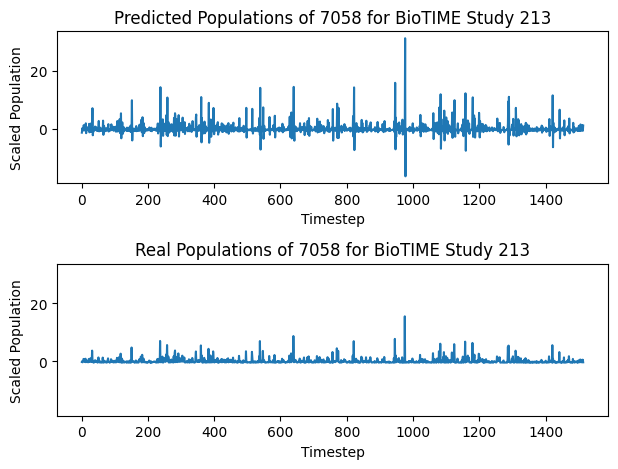

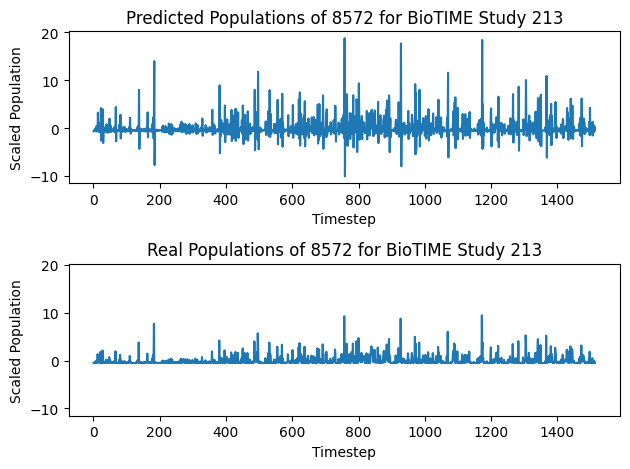

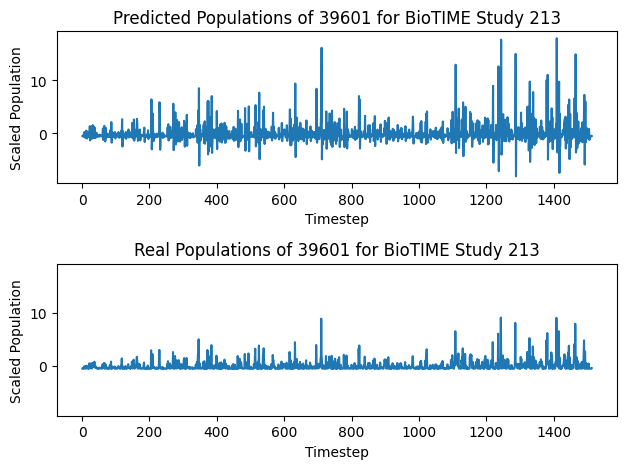

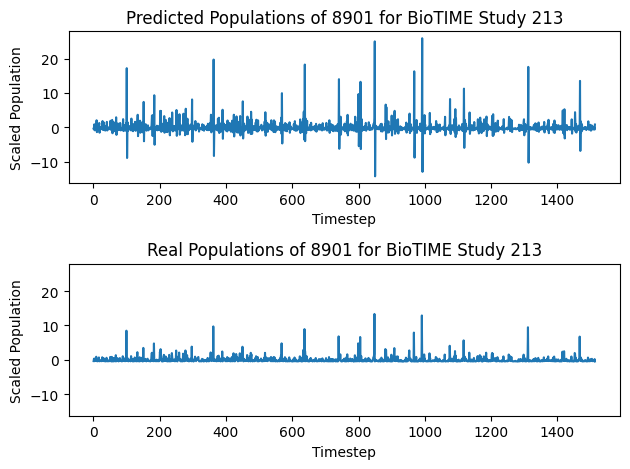

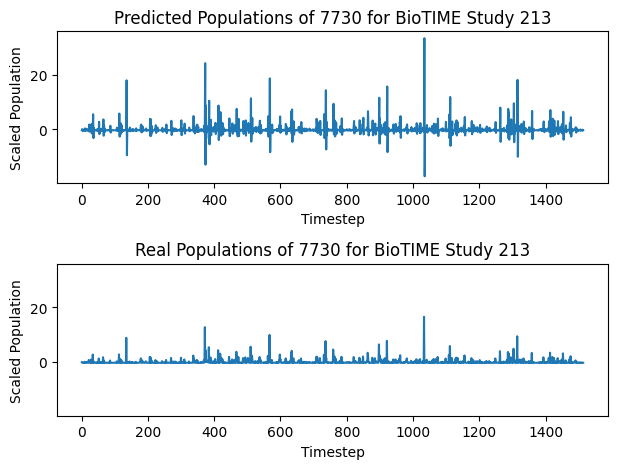

In [8]:
for i, s in enumerate(expected.columns):
    fig, (p, r) = plt.subplots(2, sharey = True)
    
    p.plot(range(1, len(predicted[i]) + 1), predicted[i])
    p.title.set_text(f'Predicted Populations of {s} for {dataset_name}')
    p.set_xlabel('Timestep')
    p.set_ylabel('Scaled Population')
    r.plot(range(1, len(predicted[i]) + 1), expected[s].tolist())
    r.title.set_text(f'Real Populations of {s} for {dataset_name}')
    r.set_xlabel('Timestep')
    r.set_ylabel('Scaled Population')
    plt.tight_layout()
    plt.show()